# Segment audios

In [82]:
import os

# Data Management
import pandas as pd

import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio
from pydub import AudioSegment

In [83]:
!ls ../../../../../mnt/e/Deep\ Learning\ Analysis/Predictions/

NOWOPAMDAY_310102_06_Model31  NOWOPAMDAY_Downsampled_Model23  WOPAMDAY_Model22


In [84]:
import pandas as pd

# Load CSV predictions.csv
df = pd.read_csv('../../../../../mnt/e/Deep Learning Analysis//Predictions/NOWOPAMDAY_310102_06_Model31/predictions_to_validate.csv')
df

,Path,Filename,StartSecond,EndSecond,MainClassification,ConfidenceScore,ConfidenceVector
0,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-05-31_07-22-35_48kHz.wav,255,258,Whistle,0.626470,"[0.373529851436615, 0.626470148563385]"
1,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-05-31_17-19-23_48kHz.wav,213,216,Whistle,0.521635,"[0.4783647358417511, 0.5216352939605713]"
2,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-05-31_18-03-05_48kHz.wav,258,261,Whistle,0.506723,"[0.4932766556739807, 0.5067233443260193]"
3,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-06-01_01-51-54_48kHz.wav,21,24,Whistle,0.542353,"[0.4576473832130432, 0.5423526763916016]"
4,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-06-02_13-06-19_48kHz.wav,234,237,Whistle,0.580354,"[0.41964584589004517, 0.5803542137145996]"
...,...,...,...,...,...,...,...
168,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-06-02_20-06-27_48kHz.wav,75,78,Background,0.770711,"[0.7707110643386841, 0.22928893566131592]"
169,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-06-02_20-23-18_48kHz.wav,210,213,Background,0.759263,"[0.7592628598213196, 0.2407371699810028]"
170,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-06-02_20-28-18_48kHz.wav,18,21,Background,0.792104,"[0.7921044826507568, 0.20789554715156555]"
171,AudiosForAnalysis/NOWOPAMDAY_310102_06_DownSam...,channelA_2024-06-02_20-33-18_48kHz.wav,222,225,Background,0.792829,"[0.7928289175033569, 0.20717108249664307]"


In [85]:
species = df["MainClassification"].unique()
species

array(['Whistle', 'Background'], dtype=object)

In [86]:
# HARD_DRIVE = "f"
# OS = "WSL"

# import subprocess
# from NO_SHARABLE import PASSWORD

# if OS == "WSL":
#     command = f'mount -t drvfs F: /mnt/{HARD_DRIVE}'

#     try:
#         # Ejecutar el comando como sudo
#         proc = subprocess.Popen(
#             ['sudo', '-S'] + command.split(),
#             stdin=subprocess.PIPE,
#             stdout=subprocess.PIPE,
#             stderr=subprocess.PIPE,
#             universal_newlines=True
#         )

#         # Enviar la contraseña seguido de un salto de línea
#         stdout, stderr = proc.communicate(PASSWORD + '\n')

#         print('STDOUT:', stdout)
#         print('STDERR:', stderr)

#         if proc.returncode == 0:
#             print("Hard drive mounted successfully")
#             HARD_DRIVE = HARD_DRIVE
#         else:
#             print("Failed to mount hard drive")

#     except Exception as e:
#         print(f"An error occurred: {e}")

In [87]:
import os

In [88]:
for specie in species:
    # Load the subset
    subset = df[df["MainClassification"] == specie]
    subset = subset.reset_index(drop=True)
    print(len(subset))

7
166


In [89]:
import os
from pydub import AudioSegment
# import pandas as pd

In [90]:
# Load CSV predictions.csv
df = pd.read_csv('../../../../../mnt/e/Deep Learning Analysis/Predictions/NOWOPAMDAY_310102_06_Model31/predictions_to_validate.csv')

species = df["MainClassification"].unique()

# take for each MainClassification the 100 samples with the highest confidence
# df = df.sort_values(by=["ConfidenceScore"], ascending=False).groupby("MainClassification").head(100)

# count of rows per MainClassification
df["MainClassification"].value_counts()

MainClassification
Background    166
Whistle         7
Name: count, dtype: int64

In [91]:
CLASSES_MAPPING = {
    'Background': 0,
    'Whistle': 1,
}

# Reverse mapping for easy lookup
IDX_TO_CLASSES = {v: k for k, v in CLASSES_MAPPING.items()}

In [92]:
def analyze_confidence_vectors(df, ignore_background=False, confidence_threshold=0.5):
    results = []

    for _, row in df.iterrows():
        confidence_vector = eval(row['ConfidenceVector'])  # Convert string to list
        main_class_idx = np.argmax(confidence_vector)
        main_class_score = confidence_vector[main_class_idx]

        # Sort classes by confidence
        sorted_classes = sorted(
            enumerate(confidence_vector), key=lambda x: x[1], reverse=True
        )

        # Filter background if necessary
        if ignore_background:
            sorted_classes = [sc for sc in sorted_classes if sc[0] != CLASSES_MAPPING['Background']]

        # Filter by confidence threshold
        sorted_classes = [sc for sc in sorted_classes if sc[1] >= confidence_threshold]

        # Create a summary for this row
        summary = {
            'Filename': row['Filename'],
            'StartSecond': row['StartSecond'],
            'EndSecond': row['EndSecond'],
            'MainClassification': IDX_TO_CLASSES[main_class_idx],
            'MainConfidenceScore': main_class_score,
            'TopClasses': [
                {
                    'Class': IDX_TO_CLASSES[class_idx],
                    'Score': score
                }
                for class_idx, score in sorted_classes[:5]  # Top 5 classifications
            ]
        }
        results.append(summary)

    return results

# Analyze with and without background, using a confidence threshold of 0.5
# results_with_background = analyze_confidence_vectors(df, ignore_background=False, confidence_threshold=0.3)
# results_without_background = analyze_confidence_vectors(df, ignore_background=True, confidence_threshold=0.3)
# df = analyze_confidence_vectors(df, ignore_background=False, confidence_threshold=0)

In [93]:
# Visualization function
def plot_top_classes(results, title):
    class_counts = {}

    for result in results:
        for entry in result['TopClasses']:
            class_name = entry['Class']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Sort by frequency
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_counts)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

print("\nPlotting results without background:")
# plot_top_classes(df, "Top Classes without Background")


Plotting results without background:


In [94]:
# df["BackgroundConfidenceScore"] = df["ConfidenceVector"].apply(lambda x: eval(x)[0])

In [95]:
# df["ConfidenceSpecieBackground"] = df["ConfidenceScore"] - df["BackgroundConfidenceScore"]

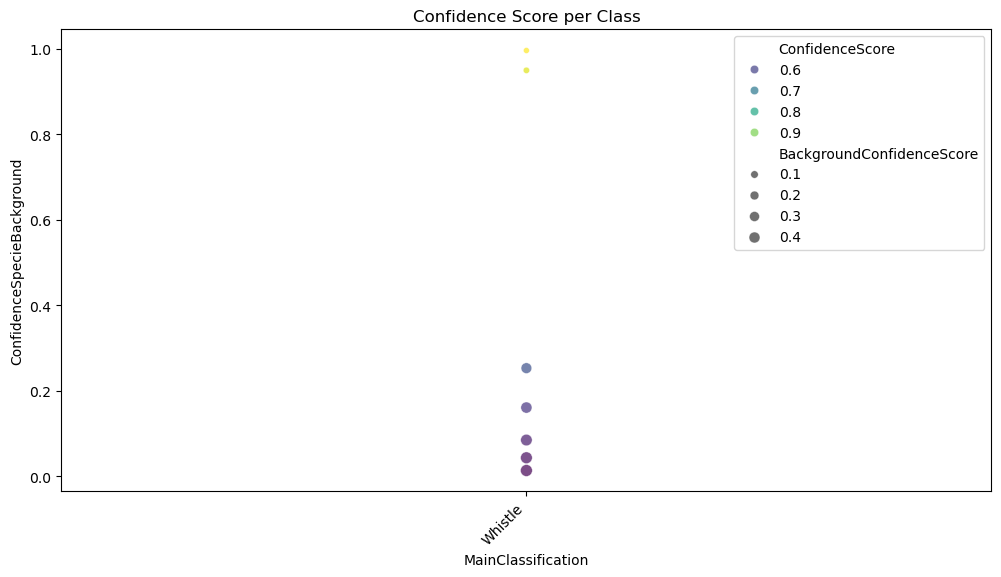

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.scatterplot(data=df, x='MainClassification', y='ConfidenceSpecieBackground', hue='ConfidenceScore', size='BackgroundConfidenceScore', palette='viridis', alpha=0.7)
# plt.title('Confidence Score per Class')
# plt.xticks(rotation=45, ha='right')
# plt.show()


In [96]:
def cut_audio(prediction, output_folder, audios_folder="../Audios/"):
    file = prediction["Path"]

    start_time = max(0, int(prediction["StartSecond"] * 1000) - 2000)  # Convert to ms
    end_time = min(1200000, int(prediction["EndSecond"] * 1000) + 2000)

    start_time = int(start_time)
    end_time = int(end_time)

    scientific_name = prediction["MainClassification"]
    confidence = prediction["ConfidenceScore"]
    # round to 2 decimals
    confidence = round(confidence, 2)

    # Get the output folder
    output_folder_specie = os.path.join(output_folder, scientific_name)
    os.makedirs(output_folder_specie, exist_ok=True)

    # Get the output file path
    base_filename = os.path.basename(file)
    output_file = os.path.join(
        output_folder_specie, f"{base_filename.replace('.wav', '')}_{start_time // 1000}_{end_time // 1000}_{confidence}.WAV"
    )

    if not os.path.exists(output_file):
        # Get the audio file
        audio_file = os.path.join(audios_folder, file)

        if not os.path.exists(audio_file):
            print(f"Warning: {audio_file} not found!")
            return

        # Load the audio file
        audio = AudioSegment.from_wav(audio_file)

        # Cut the audio segment
        cut_audio = audio[start_time:end_time]

        print(f"Exporting {output_file}...")

        # Export the cut audio segment
        cut_audio.export(output_file, format="wav")
    else:
        print(f"File {output_file} already exists")


AudioFolder = "/mnt/e/Segments_DL31/"

for specie in species:
    # Load the subset
    subset = df[df["MainClassification"] == specie]
    # reset index
    subset = subset.reset_index(drop=True)
    # For each subset saved in a csv, save in a different folder
    output_folder = f"{AudioFolder}/"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Cut the audio for each row in the subset
    for index, row in subset.iterrows():
        cut_audio(row, output_folder, audios_folder = f"/mnt/e/")

File /mnt/e/Segments_DL31//Whistle/channelA_2024-05-31_07-22-35_48kHz_253_260_0.63.WAV already exists
File /mnt/e/Segments_DL31//Whistle/channelA_2024-05-31_17-19-23_48kHz_211_218_0.52.WAV already exists
File /mnt/e/Segments_DL31//Whistle/channelA_2024-05-31_18-03-05_48kHz_256_263_0.51.WAV already exists
File /mnt/e/Segments_DL31//Whistle/channelA_2024-06-01_01-51-54_48kHz_19_26_0.54.WAV already exists
File /mnt/e/Segments_DL31//Whistle/channelA_2024-06-02_13-06-19_48kHz_232_239_0.58.WAV already exists
File /mnt/e/Segments_DL31//Whistle/channelA_2024-06-02_22-44-24_48kHz_184_191_0.97.WAV already exists
File /mnt/e/Segments_DL31//Whistle/channelA_2024-06-02_22-44-24_48kHz_187_194_1.0.WAV already exists
Exporting /mnt/e/Segments_DL31//Background/channelA_2024-05-31_00-39-18_48kHz_103_110_0.65.WAV...
Exporting /mnt/e/Segments_DL31//Background/channelA_2024-05-31_01-33-00_48kHz_286_293_0.8.WAV...
Exporting /mnt/e/Segments_DL31//Background/channelA_2024-05-31_01-33-00_48kHz_289_296_0.79.WAV